In [193]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle

In [194]:
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')

In [195]:
df_train

,x,y
0,24.0,21.549452
1,50.0,47.464463
2,15.0,17.218656
3,38.0,36.586398
4,87.0,87.288984
...,...,...
695,58.0,58.595006
696,93.0,94.625094
697,82.0,88.603770
698,66.0,63.648685


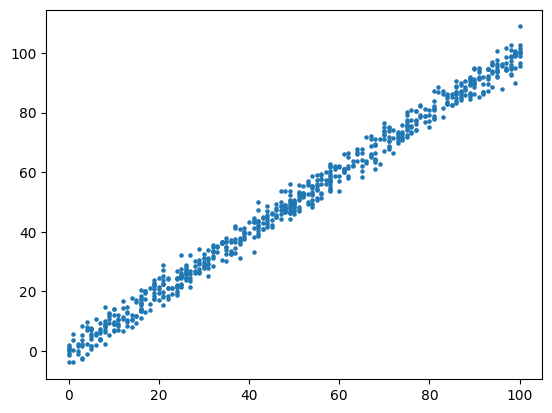

In [196]:
plt.scatter(df_train['x'], df_train['y'], s=5)

In [197]:
X_train = df_train['x'].values
y_train = df_train['y'].values

X_test = df_test['x'].values
y_test = df_test['y'].values

### Feature Standardization

To ensure all features have comparable scales, we standardize each feature using the mean and standard deviation computed from the training data.

For each feature \( j \):

$$
\mu_j = \frac{1}{m} \sum_{i=1}^{m} X_{ij}
$$

$$
\sigma_j = \sqrt{\frac{1}{m} \sum_{i=1}^{m} (X_{ij} - \mu_j)^2}
$$

We then transform both training and test data using:

$$
X^{(train)}_{ij} = \frac{X^{(train)}_{ij} - \mu_j}{\sigma_j}
$$

$$
X^{(test)}_{ij} = \frac{X^{(test)}_{ij} - \mu_j}{\sigma_j}
$$

After this transformation:

$$
\mathbb{E}[X_j] = 0
\quad \text{and} \quad
\text{Var}(X_j) = 1
$$

This ensures that each feature contributes proportionally during gradient descent and prevents features with large magnitudes from dominating the optimization process.

In [198]:
def standardize_data(X_train, X_test, eps=1e-8):
    X_train = np.asarray(X_train)
    X_test = np.asarray(X_test)

    # ensure column vectors
    if X_train.ndim == 1:
        X_train = X_train.reshape(-1, 1)
    if X_test.ndim == 1:
        X_test = X_test.reshape(-1, 1)

    mean = np.mean(X_train, axis=0)
    std = np.std(X_train, axis=0)
    std = std + eps  # avoids division by zero

    X_train_std = (X_train - mean) / std
    X_test_std  = (X_test  - mean) / std

    return X_train_std, X_test_std, mean, std

## Model Implementation

### Linear Regression Model

Linear regression is used to predict a continuous output variable from input features.

The hypothesis (model function) is defined as:

$$
f_{w,b}(x) = w x + b
$$

Where:

- \( f_{w,b}(x) \) is the predicted output  
- \( w \) is the weight parameter  
- \( b \) is the bias parameter  
- \( x \) is the input feature  

For multiple features \( x \in \mathbb{R}^n \):

$$
f_{w,b}(x) = w^T x + b
$$

---

### Model Training

The goal of training is to find optimal parameters \( (w, b) \) that best fit the dataset.

---

### Forward Pass

During the forward pass, we compute predictions for each training example:

$$
\hat{y}^{(i)} = f_{w,b}(x^{(i)})
$$

---

### Cost Function

To measure how well the model performs, we use the Mean Squared Error (MSE) cost function:

$$
J(w,b) = \frac{1}{2m} \sum_{i=1}^{m} \left( f_{w,b}(x^{(i)}) - y^{(i)} \right)^2
$$

Where:

- \( m \) is the number of training examples  
- \( x^{(i)} \) is the \( i \)-th input  
- \( y^{(i)} \) is the true output  

The factor \( \frac{1}{2} \) simplifies gradient calculations.

---

### Backward Pass (Gradient Computation)

We compute the gradients of the cost function with respect to \( w \) and \( b \).

Gradient with respect to bias:

$$
\frac{\partial J}{\partial b}
=
\frac{1}{m}
\sum_{i=1}^{m}
\left( f_{w,b}(x^{(i)}) - y^{(i)} \right)
$$

Gradient with respect to weight:

$$
\frac{\partial J}{\partial w}
=
\frac{1}{m}
\sum_{i=1}^{m}
\left( f_{w,b}(x^{(i)}) - y^{(i)} \right) x^{(i)}
$$

---

### Parameter Update (Gradient Descent)

Using gradient descent, parameters are updated as:

$$
w \leftarrow w - \alpha \frac{\partial J}{\partial w}
$$

$$
b \leftarrow b - \alpha \frac{\partial J}{\partial b}
$$

Where:

- \( \alpha \) is the learning rate  

---

By repeatedly performing:

1. Forward pass  
2. Cost computation  
3. Gradient computation  
4. Parameter update  

the model gradually minimizes the cost function and learns the best-fitting line.

In [199]:
class LinearRegression:
    def __init__(self, learning_rate=0.01, convergence_tol=1e-6):
        self.learning_rate = learning_rate
        self.convergence_tol = convergence_tol
        self.w = None
        self.b = None
        self.costs = []

    def initialize_parameters(self, n_features):
        self.w = np.random.randn(n_features) * 0.01  # shape: (n_features,)
        self.b = 0.0

    def forward(self, X):
        X = np.asarray(X)
        # ensure 2D: (m, n_features)
        if X.ndim == 1:
            X = X.reshape(1, -1)
        return (X @ self.w + self.b).reshape(-1)  # returns shape (m,)

    def compute_cost(self, predictions):
        m = len(predictions)
        return np.sum((predictions - self.y) ** 2) / (2 * m)

    def backward(self, predictions):
        m = len(predictions)
        error = (predictions - self.y).reshape(-1)        # (m,)
        # X stored as (m, n_features)
        self.dW = (self.X.T @ error) / m                  # (n_features,)
        self.db = np.sum(error) / m                       # scalar

    def fit(self, iterations, X, y, verbose=True):
        # cast & reshape
        X = np.asarray(X)
        y = np.asarray(y)

        if X.ndim == 1:
            X = X.reshape(-1, 1)
        y = y.reshape(-1)

        self.X = X
        self.y = y

        self.initialize_parameters(X.shape[1])
        self.costs = []

        for i in range(iterations):
            preds = self.forward(self.X)         # (m,)
            cost = self.compute_cost(preds)

            # check numeric health
            if np.isnan(cost) or np.isinf(cost):
                print(f"Numeric issue at iteration {i}: cost={cost}")
                break

            self.backward(preds)

            # gradient step
            self.w -= self.learning_rate * self.dW
            self.b -= self.learning_rate * self.db

            self.costs.append(cost)

            if verbose and (i % 100 == 0 or i == iterations - 1):
                print(f'Iteration: {i}, Cost: {cost}')

            if i > 0 and abs(self.costs[-1] - self.costs[-2]) < self.convergence_tol:
                if verbose:
                    print(f'Converged after {i} iterations.')
                break

        return self

    def predict(self, X):
        X = np.asarray(X)
        if X.ndim == 1:
            X = X.reshape(-1, 1)
        return (X @ self.w + self.b).reshape(-1)

    def plot(self, X_train, y_train, X_test=None, y_test=None, show_loss=True):
        # flatten for plotting
        X_train_flat = np.asarray(X_train).reshape(-1)
        y_train_flat = np.asarray(y_train).reshape(-1)

        plt.figure(figsize=(9, 5))

        # left: data + fit
        plt.subplot(1, 2, 1)
        plt.scatter(X_train_flat, y_train_flat, s=20, alpha=0.7, label='Train Data', color='tab:blue')

        if X_test is not None and y_test is not None:
            X_test_flat = np.asarray(X_test).reshape(-1)
            y_test_flat = np.asarray(y_test).reshape(-1)
            plt.scatter(X_test_flat, y_test_flat, s=20, alpha=0.7, label='Test Data', color='tab:green')

        # smooth line
        x_min = np.min(X_train_flat) if X_test is None else min(np.min(X_train_flat), np.min(np.asarray(X_test).reshape(-1)))
        x_max = np.max(X_train_flat) if X_test is None else max(np.max(X_train_flat), np.max(np.asarray(X_test).reshape(-1)))
        X_line = np.linspace(x_min, x_max, 300).reshape(-1, 1)
        y_line = self.predict(X_line)

        plt.plot(X_line.flatten(), y_line.flatten(), linewidth=2, color='tab:red', label='Regression Line')
        plt.xlabel("X")
        plt.ylabel("y")
        plt.title("Linear Regression Fit")
        plt.legend()
        plt.grid(alpha=0.25)

        # right: loss curve
        if show_loss:
            plt.subplot(1, 2, 2)
            plt.plot(self.costs, linewidth=1.5)
            plt.xlabel("Iteration")
            plt.ylabel("Cost (MSE/2)")
            plt.title("Training Loss")
            plt.grid(alpha=0.25)

        plt.tight_layout()
        plt.show()

    def save_model(self, filename):
        model_data = {
            'learning_rate': self.learning_rate,
            'convergence_tol': self.convergence_tol,
            'w': self.w,
            'b': self.b
        }
        with open(filename, 'wb') as file:
            pickle.dump(model_data, file)

In [200]:
# Remove rows with NaN in x or y
df_train = df_train.dropna(subset=['x', 'y'])
df_test  = df_test.dropna(subset=['x', 'y'])

# Re-extract arrays
X_train = df_train['x'].values
y_train = df_train['y'].values
X_test  = df_test['x'].values
y_test  = df_test['y'].values   

Iteration: 0, Cost: 1670.2177332085685
Iteration: 100, Cost: 1368.0352053969507
Iteration: 200, Cost: 1120.6538327064602
Iteration: 300, Cost: 918.1353615115197
Iteration: 400, Cost: 752.3438521142064
Iteration: 500, Cost: 616.6188270038729
Iteration: 600, Cost: 505.50769406247093
Iteration: 700, Cost: 414.54669513477967
Iteration: 800, Cost: 340.0815798318247
Iteration: 900, Cost: 279.1208003499463
Iteration: 1000, Cost: 229.21532958126383
Iteration: 1100, Cost: 188.360274350479
Iteration: 1200, Cost: 154.9143312063471
Iteration: 1300, Cost: 127.53384899964122
Iteration: 1400, Cost: 105.11884928978054
Iteration: 1500, Cost: 86.76883601389974
Iteration: 1600, Cost: 71.7466191241596
Iteration: 1700, Cost: 59.44869885077154
Iteration: 1800, Cost: 49.381020813590084
Iteration: 1900, Cost: 41.13912797259643
Iteration: 2000, Cost: 34.391912045393745
Iteration: 2100, Cost: 28.86831162415738
Iteration: 2200, Cost: 24.346422604647124
Iteration: 2300, Cost: 20.644583451663703
Iteration: 2400, C

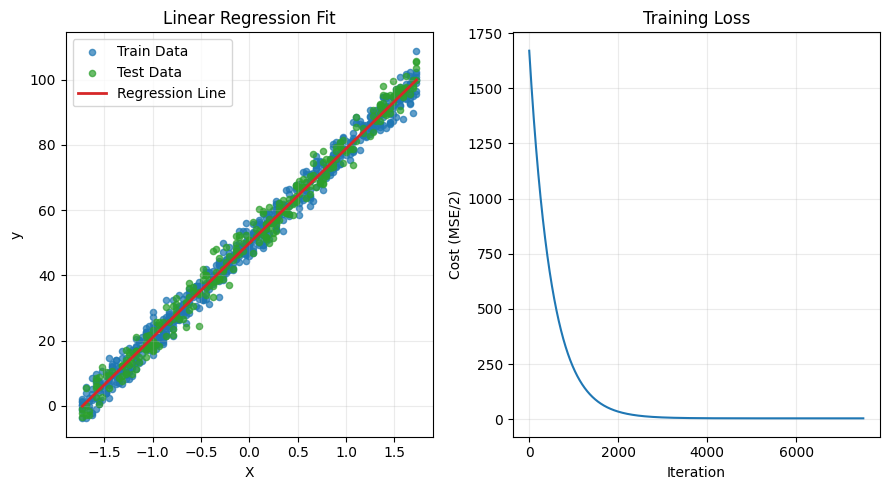

In [201]:
X_train_std, X_test_std, mean, std = standardize_data(X_train, X_test)

lr = LinearRegression(learning_rate=0.001)
lr.fit(10000, X_train_std, y_train)

lr.plot(X_train_std, y_train, X_test_std, y_test)

### Regression Evaluation Metrics

#### 1. Mean Squared Error (MSE)

**Formula:**

$$
\text{MSE} = \frac{1}{n} \sum_{i=1}^{n} \left( y_{\text{true}, i} - y_{\text{pred}, i} \right)^2
$$

**Description:**  
Mean Squared Error (MSE) measures the average squared difference between the predicted values \(y_{\text{pred}}\) and the actual target values \(y_{\text{true}}\).  

**Interpretation:**  
- Lower MSE → better model fit.  
- Sensitive to outliers because squaring magnifies large errors.

---

#### 2. Root Mean Squared Error (RMSE)

**Formula:**

$$
\text{RMSE} = \sqrt{\text{MSE}} = \sqrt{\frac{1}{n} \sum_{i=1}^{n} \left( y_{\text{true}, i} - y_{\text{pred}, i} \right)^2 }
$$

**Description:**  
RMSE is the square root of MSE, giving the error in the same unit as the target variable.  

**Interpretation:**  
- Lower RMSE → better model fit.  
- Still sensitive to outliers, but more interpretable than MSE.

---

#### 3. R-squared (\(R^2\))

**Formula:**

$$
R^2 = 1 - \frac{\text{SSR}}{\text{SST}} 
= 1 - \frac{\sum_{i=1}^{n} \left(y_{\text{true}, i} - y_{\text{pred}, i}\right)^2}{\sum_{i=1}^{n} \left(y_{\text{true}, i} - \bar{y}_{\text{true}}\right)^2}
$$

Where:  
- \(\text{SSR} = \sum_{i=1}^{n} (y_{\text{true}, i} - y_{\text{pred}, i})^2\) (residual sum of squares)  
- \(\text{SST} = \sum_{i=1}^{n} (y_{\text{true}, i} - \bar{y}_{\text{true}})^2\) (total sum of squares)  

**Description:**  
R-squared measures the proportion of variance in the target variable explained by the model.  

**Interpretation:**  
- \(R^2\) closer to 1 → model explains more variance.  
- \(R^2\) closer to 0 → model explains little to no variance.  
- Negative \(R^2\) indicates the model performs worse than predicting the mean.

In [202]:
def mean_squared_error(y_true, y_pred):
    y_true = np.asarray(y_true).reshape(-1)
    y_pred = np.asarray(y_pred).reshape(-1)

    assert y_true.shape == y_pred.shape, "Shapes must match."
    assert not np.isnan(y_true).any(), "y_true contains NaN."
    assert not np.isnan(y_pred).any(), "y_pred contains NaN."

    return np.mean((y_true - y_pred) ** 2)


def root_mean_squared_error(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))


def r_squared(y_true, y_pred):
    y_true = np.asarray(y_true).reshape(-1)
    y_pred = np.asarray(y_pred).reshape(-1)

    assert y_true.shape == y_pred.shape, "Shapes must match."

    ss_total = np.sum((y_true - np.mean(y_true)) ** 2)

    if ss_total == 0:
        return 0.0  # avoids division by zero if y is constant

    ss_residual = np.sum((y_true - y_pred) ** 2)

    return 1 - (ss_residual / ss_total)

In [203]:
y_pred = lr.predict(X_test)
mse_value = mean_squared_error(y_test, y_pred)
rmse_value = root_mean_squared_error(y_test, y_pred)
r_squared_value = r_squared(y_test, y_pred)

print(f"Mean Squared Error (MSE): {mse_value}")
print(f"Root Mean Squared Error (RMSE): {rmse_value}")
print(f"R-squared (Coefficient of Determination): {r_squared_value}")

Mean Squared Error (MSE): 2800112.8860672014
Root Mean Squared Error (RMSE): 1673.3537838924562
R-squared (Coefficient of Determination): -3323.2317821344745
